In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
sys.path.append("..")

In [4]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [5]:
from pyro import distributions as dist

In [6]:
from model import YModel, OptLoss
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


from collections import defaultdict
%matplotlib inline

In [7]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

['shir994']

In [8]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [9]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [10]:
exp = comet_api.get("shir994/2d-mu/f6432030afa64685b5df9497ec03bd9b")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [11]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [12]:
generator = Generator(NOISE_DIM, out_dim = 1, input_param=3).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1, input_param=3).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [13]:
import io

#asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == f"{hyper_params['data_size']}_999.tar"][0]
asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "2d_mu_mu_2d.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [14]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [15]:
generator.load_state_dict(state_dict['gen_state_dict'])

In [12]:
# y_true = []
# y_gen = []
# for i in range(5000):
#     x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1]))
#     y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
#     y_true.append(y_sampler.condition_sample().mean().item())
#     noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
#     y_gen.append(generator(noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).mean().item())
# # plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
# # plt.hist(generator(fixed_noise, torch.cat([mu.to(device), x_r.to(device)], dim=1)).detach().cpu().numpy(),
# #          bins=100, color='g', density=True, alpha=0.5, label='gan');
# # plt.legend()

In [13]:
# plt.hist(y_true, bins=100, density=True, label='true');
# plt.hist(y_gen, bins=100, density=True, label='true');

In [16]:
%%time
my_cmap = plt.cm.jet
my_cmap.set_under('white')
mu_range = (-10,10)
mu = dist.Uniform(*mu_range).sample([10000, 2]).to(device)

y = np.zeros([len(mu), 1])

for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    y[i, 0] = generator(noise, torch.cat([mu_r,x_r],dim=1)).mean().item()

CPU times: user 9.32 s, sys: 36 ms, total: 9.36 s
Wall time: 9.91 s


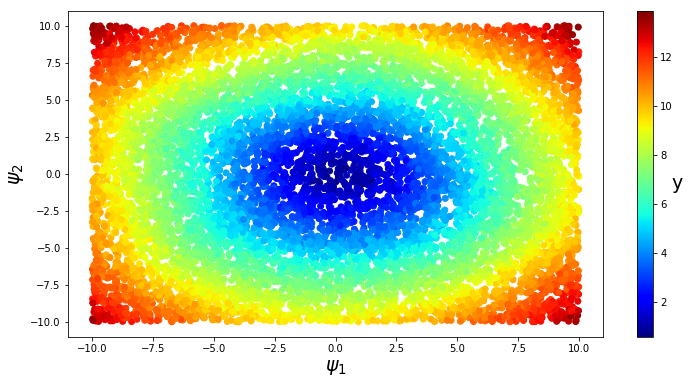

In [17]:
plt.figure(figsize=(12,6))
mu = mu.cpu().numpy()
plt.scatter(mu[:,0], mu[:, 1], c=y[:,0], cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

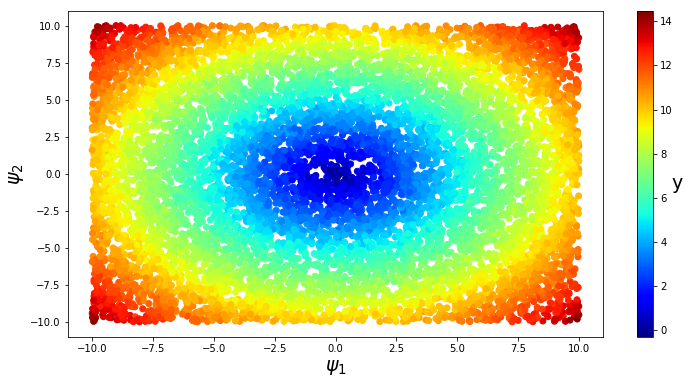

In [18]:
mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

y = y_sampler.condition_sample()
y_mean = y.mean(dim=1)

plt.figure(figsize=(12,6))
plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

CPU times: user 10.8 s, sys: 128 ms, total: 11 s
Wall time: 11 s


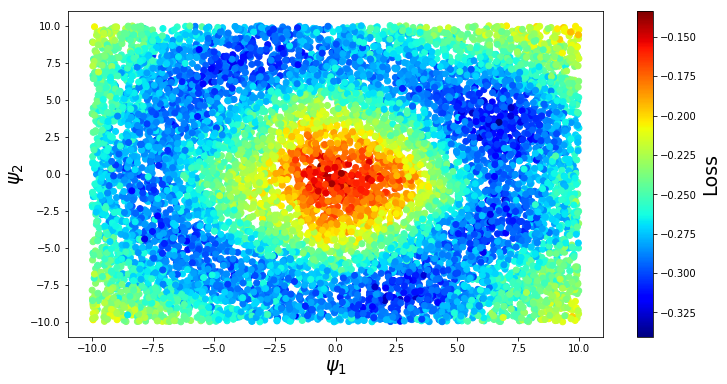

In [41]:
%%time
plt.figure(figsize=(12,6))
mu_range = (-10,10)
mu = dist.Uniform(*mu_range).sample([10000, 2]).to(device)

y = np.zeros([len(mu), 1])

rs = []
for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    samples = generator(noise, torch.cat([mu_r,x_r],dim=1))
    rs.append(OptLoss.SigmoidLoss(samples, 5, 10).mean().item())

mu = mu.cpu().numpy()
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

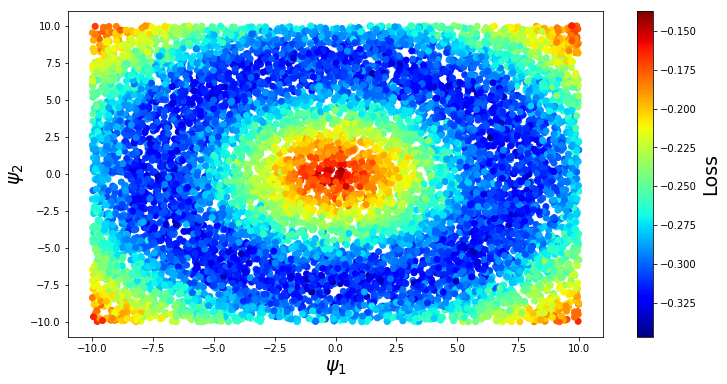

In [26]:
import numpy as np
plt.figure(figsize=(12,6))
mu = dist.Uniform(-10,10).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

# Test optimisation

In [19]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [43]:
io_model = InputOptimisation(generator)

lr = 50
average_size = 1000

mu_optim = torch.tensor([-1.,-1.]).reshape(1,-1)
mu_optim = mu_optim.repeat(average_size, 1).to(device)
mu_optim.requires_grad=True

In [61]:
%%time
n_iter = 100
losses = []
m_vals = []
for _iter in range(n_iter):
    noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([average_size, 1]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
    loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].detach().cpu().numpy())
m_vals =np.array(m_vals)    

CPU times: user 184 ms, sys: 8 ms, total: 192 ms
Wall time: 190 ms


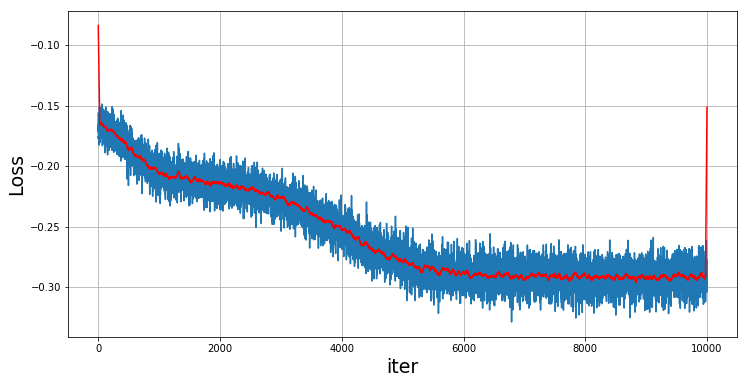

In [48]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

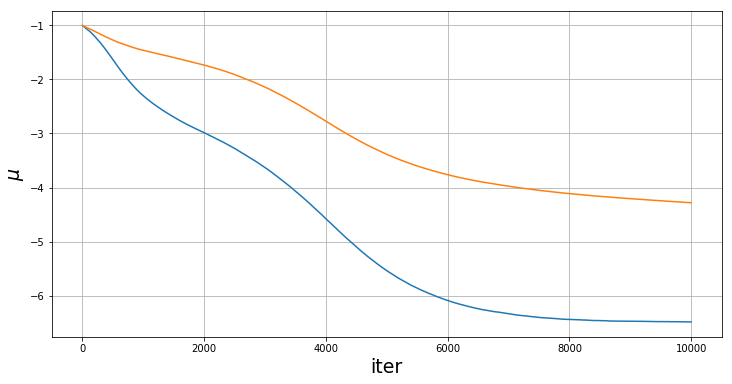

In [49]:
plt.figure(figsize=(12,6))
plt.plot(m_vals[:,0]);
plt.plot(m_vals[:,1]);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [20]:
from torch import nn

In [ ]:
def find_mu(init_mu, n_iter=100000, average_size=1000):
    mu_optim = torch.tensor(init_mu).reshape(1,-1)
    mu_optim = mu_optim.repeat([average_size, 1]).to(device)
    mu_optim.requires_grad=True
    #losses = []
    m_vals = []
    lr = 50.
    for _iter in range(n_iter):
        X = y_sampler.x_dist.sample([average_size, 1]).to(device)
        y_sampler.make_condition_sample({"mu": mu_optim, "X":X})
        # Do an update
        samples = y_sampler.condition_sample()
        loss = OptLoss.SigmoidLoss(samples, 5, 10).mean()
        #losses.append(loss.item())
        loss.backward()       
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
            mu_optim.grad.zero_()
        m_vals.append(mu_optim[0].detach().cpu().numpy().copy())
    return m_vals

In [70]:
def find_mu(init_mu, n_iter=100000, average_size=1000, lr = 50.):
    io_model = InputOptimisation(generator)
    mu_optim = torch.tensor(init_mu).reshape(1,-1)
    mu_optim = mu_optim.repeat([average_size, 1]).to(device)
    mu_optim.requires_grad=True
    #losses = []
    m_vals = []
    grad_list = []
    for _iter in range(n_iter):
        noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
        x = y_sampler.x_dist.sample([average_size, 1]).to(device)
        
        # Find true grads
        y_sampler.make_condition_sample({"mu": mu_optim, "X":x})
        samples = y_sampler.condition_sample()
        loss = OptLoss.SigmoidLoss(samples, 5, 10).mean()
        loss.backward()
        with torch.no_grad():
            true_grads = mu_optim.grad.mean(dim=0, keepdim=True).detach()
            mu_optim.grad.zero_()
        
        
        # Do an update for the surrogate
        data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
        #losses.append(loss.item())
        io_model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            grad_dist = nn.functional.cosine_similarity(true_grads,
                                            mu_optim.grad.mean(dim=0, keepdim=True), dim=1, eps=1e-10)
            mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
            mu_optim.grad.zero_()
        m_vals.append(mu_optim[0].detach().cpu().numpy())
        grad_list.append(grad_dist.detach().cpu().numpy())
    return m_vals, grad_list

In [86]:
%%time
#various_restarts = []
#for _ in range(10):
opt_mu = []
opt_grad = []
for mu in [[0.,0.05], [0., 2.], [0., -2.], [2., 0.], [10., 10.], [-10., 0.], [0., 7.], [0., 10.]]:
    mus, grad_cos = find_mu(mu, n_iter=10000)
    opt_mu.append(mus)
    opt_grad.append(grad_cos)
    #various_restarts.append(opt_mu[-1])

CPU times: user 4min 14s, sys: 10.9 s, total: 4min 25s
Wall time: 4min 28s


In [87]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

In [ ]:
from itertools import product
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
mu = torch.tensor(np.array(list(product(x,y)))).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

In [ ]:
loss_val = np.zeros([len(mu), 1])
for i in range(len(mu)):
    noise = torch.Tensor(sample_noise(1000, NOISE_DIM)).to(device)
    mu_r = mu[i, :].reshape(1,-1).repeat(1000, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    samples = generator(noise, torch.cat([mu_r,x_r],dim=1))
    loss_val[i, 0] = OptLoss.SigmoidLoss(samples, 5, 10).mean().item()

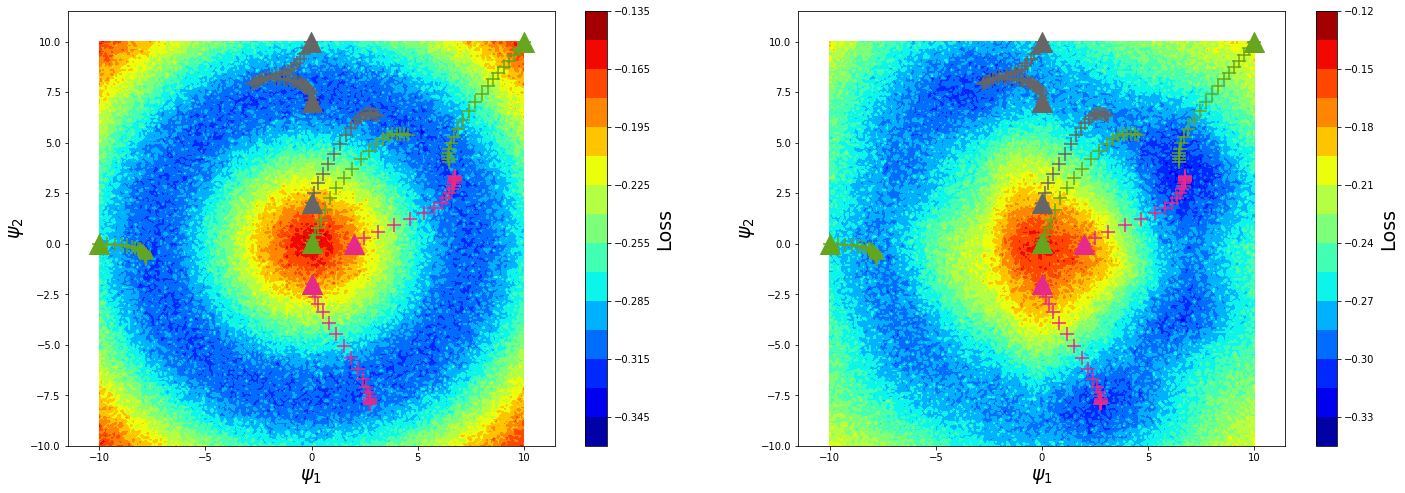

In [122]:
plt.figure(figsize=(24,8))
# mu = dist.Uniform(-10,10).sample([10000, 2])
# x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
# y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
# samples = y_sampler.condition_sample()
# rs = OptLoss.SigmoidLoss(samples, 5, 10)
# plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)

plt.subplot(1,2,1)
plt.contourf(*np.meshgrid(x,y), torch.transpose(rs.reshape(-1, x.shape[0]), 1,0), cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)


for index, mu_path in enumerate(opt_mu):
    mus = np.array(mu_path)
    plt.scatter(mus[0, 0], mus[0, 1], c=np.array(cmap(index)).reshape(1,-1), marker='^', s=400)
    plt.scatter(mus[::500, 0], mus[::500, 1], c=np.array(cmap(index)).reshape(1,-1), marker='+', s=200)
    plt.grid()
    plt.grid()
    
plt.subplot(1,2,2)    

plt.contourf(*np.meshgrid(x,y), loss_val.reshape(-1, x.shape[0]).T, cmap=my_cmap, levels=15)

cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)


for index, mu_path in enumerate(opt_mu):
    mus = np.array(mu_path)
    plt.scatter(mus[0, 0], mus[0, 1], c=np.array(cmap(index)).reshape(1,-1), marker='^', s=400)
    plt.scatter(mus[::500, 0], mus[::500, 1], c=np.array(cmap(index)).reshape(1,-1), marker='+', s=200)
    plt.grid()
    plt.grid()

In [146]:
opt_mu[4][6000]

array([6.8873096, 5.6846657], dtype=float32)

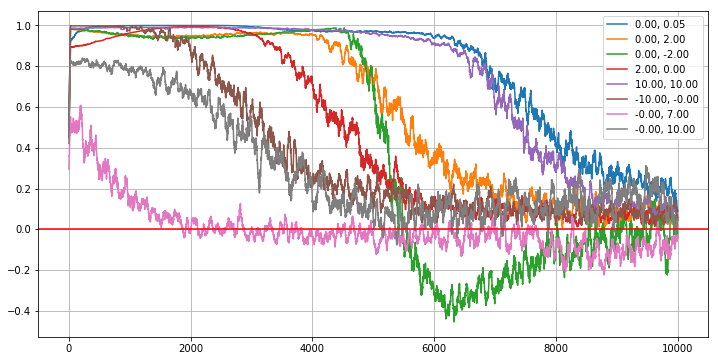

In [140]:
plt.figure(figsize=(12,6))
for grads, mus in zip(opt_grad, opt_mu):
    grads_angle =  np.array(grads)
    plt.plot(movingaverage(grads_angle[:,0],50), alpha=1, label="{:.2f}, {:.2f}".format(*mus[0]))
plt.legend()
plt.axhline(y=0, color='r', linestyle='-')
plt.grid()